<a href="https://colab.research.google.com/github/FaisalAhmedBijoy/Deep-CNN-Architecture-Implementation/blob/main/Custom_SqueezeNet_Architecture_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import glob

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path='/content/drive/My Drive/CSE 4000 Thesis/Dataset1500/train'
test_path='/content/drive/My Drive/CSE 4000 Thesis/Dataset1500/test'

In [4]:
print(os.listdir(train_path))
print(os.listdir(test_path))

['building_house', 'mosque', 'temple', 'tinshed', 'mud_house', 'sky_building']
['mud_house', 'building_house', 'mosque', 'sky_building', 'temple', 'tinshed']


## Dataset Preparatin using ImageDataGenerator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
WIDTH=224
HEIGHT=224

In [7]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    #horizontal_flip=True,
                                    #shear_range=0.1 ,
                                    #zoom_range=0.1,
                                    #rotation_range=20,
                                    #height_shift_range=0.1,
                                    fill_mode='nearest',
                                    validation_split=0.2)
                                     
train_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT),
                                                 class_mode='categorical',
                                                 subset='training')

validation_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical',
                                                 subset='validation')

Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [8]:
test_generator=ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(batch_size=32,
                                                 directory=test_path,
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical')

Found 300 images belonging to 6 classes.


In [9]:
train_dataset.class_indices

{'building_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'sky_building': 3,
 'temple': 4,
 'tinshed': 5}

In [10]:
validation_dataset.class_indices

{'building_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'sky_building': 3,
 'temple': 4,
 'tinshed': 5}

In [11]:
total_class=len(train_dataset.class_indices)
print('Number of classes in dataset: ',total_class)

Number of classes in dataset:  6


## Plot some random image
- class 0: building house
- class 1: mosque
- class 2: mud house
- class 3: sky building
- class 4: temple
- class 5: tinshed

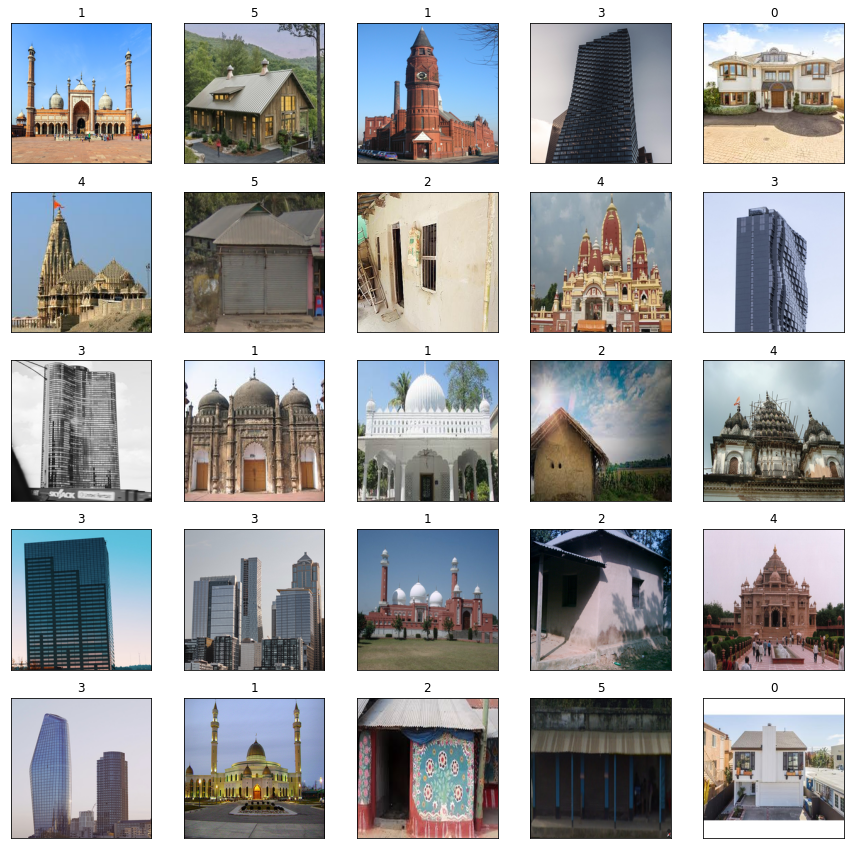

In [12]:
x,y=train_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

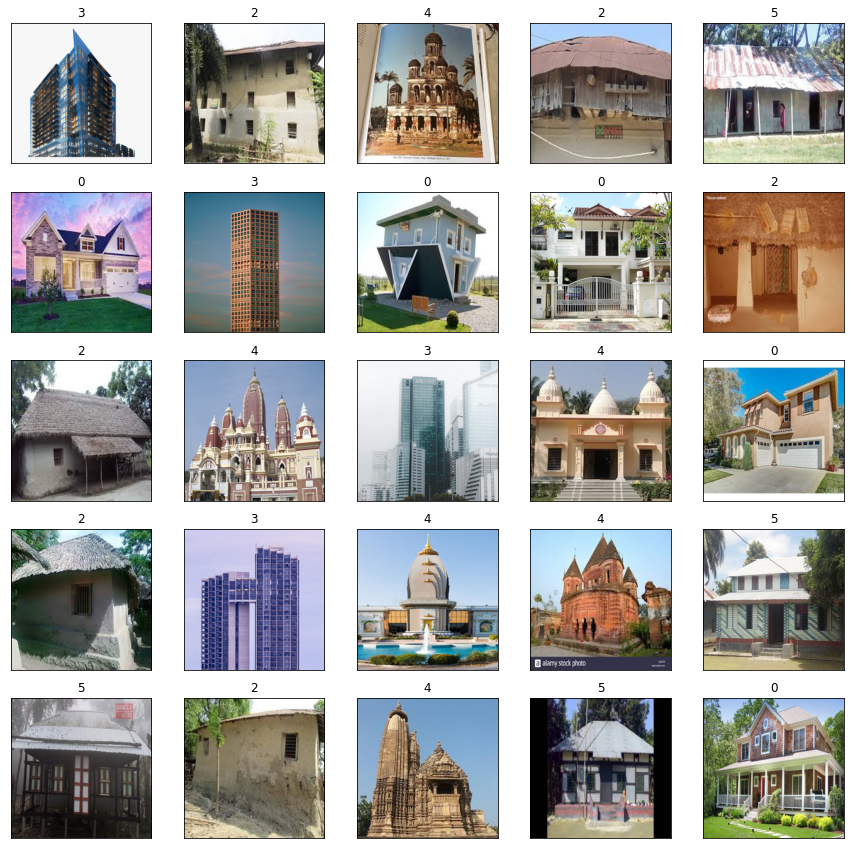

In [13]:
x,y=validation_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Import Library

In [14]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf


## Fire Block

In [15]:
def fire_block(x,squeeze_filters,expand_filters):
    squeezed=layers.Conv2D(filters=squeeze_filters,kernel_size=1,activation='relu')(x)
    expanded_1x1=layers.Conv2D(filters=expand_filters,kernel_size=1,activation='relu')(squeezed)
    expanded_3x3=layers.Conv2D(filters=expand_filters,kernel_size=3,padding='same',activation='relu')(squeezed)
    
    output=layers.Concatenate()([expanded_1x1,expanded_3x3])
    return output

## Model  Stem

In [16]:
IMG_SHAPE=(224,224,3)
input=layers.Input(IMG_SHAPE)
total_class=6

In [17]:
x=layers.Conv2D(96,7,strides=2,padding='same',activation='relu')(input)
x=layers.MaxPool2D(3,strides=2,padding='same')(x)

## Main Part

In [18]:
x=fire_block(x,squeeze_filters=16,expand_filters=64)
x=fire_block(x,squeeze_filters=16,expand_filters=64)
x=fire_block(x,squeeze_filters=32,expand_filters=128)
x=layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)

x=fire_block(x,squeeze_filters=32,expand_filters=128)
x=fire_block(x,squeeze_filters=48,expand_filters=192)
x=fire_block(x,squeeze_filters=48,expand_filters=192)
x=fire_block(x,squeeze_filters=64,expand_filters=256)
x=layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)

x=fire_block(x,squeeze_filters=64,expand_filters=256)

## Last Part 

In [19]:
x=layers.Conv2D(filters=total_class,kernel_size=1)(x)
x=layers.GlobalAvgPool2D()(x)

In [20]:
output=layers.Activation('softmax')(x)

## Define Model

In [21]:
model=keras.Model(input,output)

## Analysis DenseNet Model

In [22]:
model.layers


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 96) 14208       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 96)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 16)   1552        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [24]:
import time
print(time.time())

1622731369.363669


In [25]:
t=time.time()
image_name='/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/SqueezeNet'+str(int(t))+'.png'
image_name

'/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/SqueezeNet1622731369.png'

/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/SqueezeNet1622731369.png


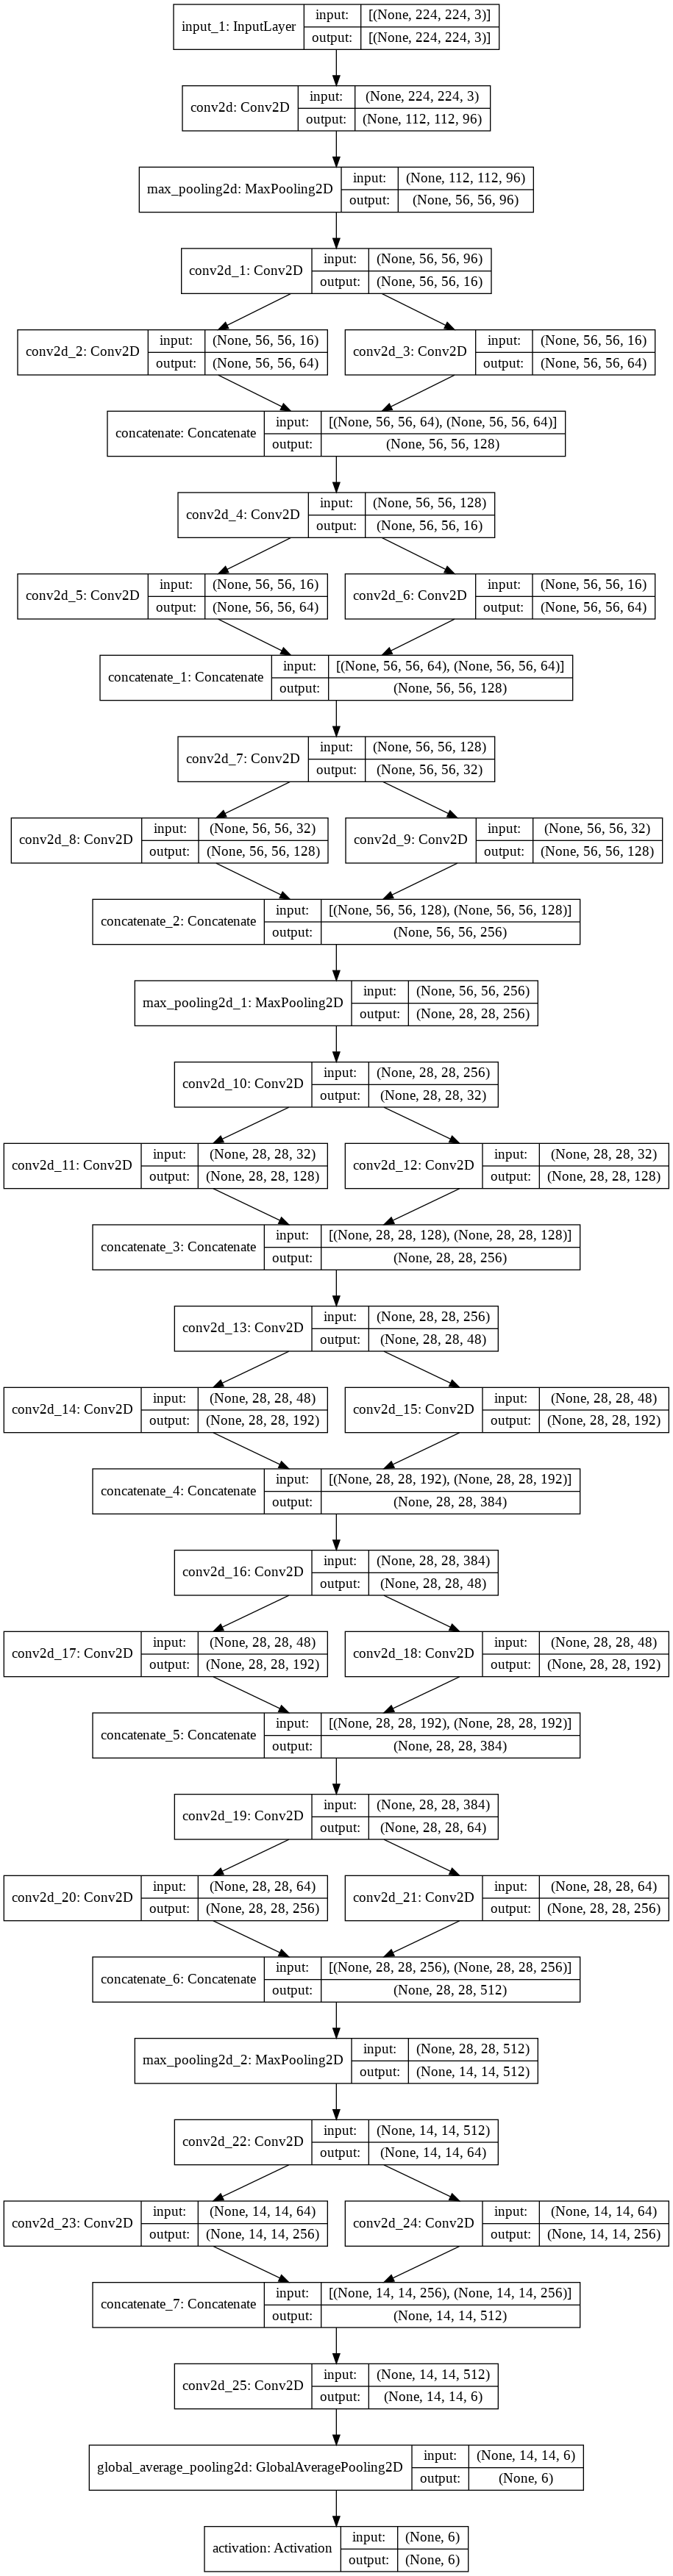

In [26]:
t=time.time()
image_name='/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/SqueezeNet'+str(int(t))+'.png'
print(image_name)
keras.utils.plot_model(model,show_shapes=True,to_file=image_name)

In [27]:
## Compile The Model 

In [28]:
model.compile( loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Trained the Model

In [29]:
epochs=200
batch_size=32
trainset_length=len(train_dataset.labels)
validation_length=len(validation_dataset.labels)
steps_per_epoch=(trainset_length//batch_size)
validation_steps=(validation_length//batch_size)
print(trainset_length)
print(validation_length)
print(steps_per_epoch)
print(validation_steps)

960
240
30
7


In [30]:
history = model.fit(train_dataset,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps)

Epoch 1/200
30/30 [==============================] - 426s 13s/step - loss: 1.7936 - accuracy: 0.1469 - val_loss: 1.7920 - val_accuracy: 0.1741
Epoch 2/200
30/30 [==============================] - 5s 172ms/step - loss: 1.7924 - accuracy: 0.1490 - val_loss: 1.7918 - val_accuracy: 0.1607
Epoch 3/200
30/30 [==============================] - 5s 172ms/step - loss: 1.7920 - accuracy: 0.1385 - val_loss: 1.7917 - val_accuracy: 0.1741
Epoch 4/200
30/30 [==============================] - 5s 174ms/step - loss: 1.7919 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1652
Epoch 5/200
30/30 [==============================] - 5s 172ms/step - loss: 1.7920 - accuracy: 0.1615 - val_loss: 1.7917 - val_accuracy: 0.1607
Epoch 6/200
30/30 [==============================] - 5s 171ms/step - loss: 1.7918 - accuracy: 0.1448 - val_loss: 1.7918 - val_accuracy: 0.1607
Epoch 7/200
30/30 [==============================] - 5s 173ms/step - loss: 1.7920 - accuracy: 0.1417 - val_loss: 1.7918 - val_accuracy: 0.1696

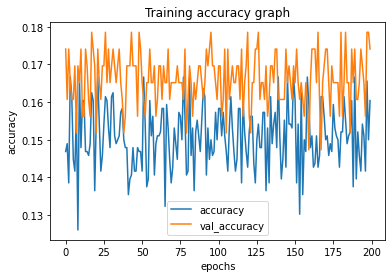

In [31]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training accuracy graph')
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

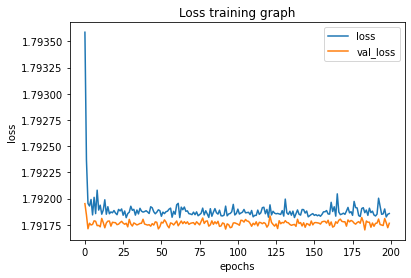

In [32]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss training graph')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()


In [33]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print('Test Loss: ',test_loss)
print('Test Accuracy: ',test_accuracy)


10/10 [==============================] - 92s 10s/step - loss: 1.7918 - accuracy: 0.1667
Test Loss:  1.7917604446411133
Test Accuracy:  0.1666666716337204


## Saved Model

In [ ]:
import time
t = time.time()

export_path_keras = "/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/SqueezeNet{}_model_{}.h5".format(test_accuracy,int(t))
print(export_path_keras)
model.save(export_path_keras)

In [ ]:
from tensorflow.keras.models import load_model

In [36]:
model_path=export_path_keras
reload_model=load_model(model_path)
reload_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 96) 14208       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 96)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 16)   1552        max_pooling2d[0][0]              
______________________________________________________________________________________________